In [56]:
import pandas as pd
%matplotlib inline
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats
import math

In [57]:
data = pd.read_csv("data/with_scores.csv")
data = data[data['state']=='California']
data = data[data['ethnicity'] == 'All']
berkeley_data = data[data['campus'] == 'Berkeley']

In [58]:
X_cols = ['year', 
        'app_num', 'adm_num', 
        'app_gpa', 'adm_gpa',
       'distance',
       'ap_num_scr1', 'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
       'ap_num_test_takers',
       'enroll12',
       'sat_total_avg', 'sat_num_test_takers']
y_col = ['yield']
relevant = berkeley_data[X_cols + y_col + ['school_num']].dropna()
X = relevant[X_cols]
y = relevant[y_col]

In [59]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1533.0,2006.438356,5.123120,1998.000000,2002.000000,2006.000000,2011.000000,2015.000000
app_num,1533.0,76.707110,46.185257,11.000000,43.000000,68.000000,97.000000,308.000000
adm_num,1533.0,19.054142,11.516321,5.000000,11.000000,16.000000,24.000000,86.000000
app_gpa,1533.0,3.849583,0.117607,3.271579,3.774948,3.855942,3.932885,4.112941
adm_gpa,1533.0,4.162445,0.096072,3.495000,4.116304,4.181429,4.229286,4.362500
distance,1533.0,358743.354207,292128.519051,662.000000,51515.000000,302470.000000,634670.000000,958441.000000
ap_num_scr1,1533.0,83.444879,73.315471,0.000000,34.000000,62.000000,113.000000,581.000000
ap_num_scr2,1533.0,140.981083,85.277999,0.000000,80.000000,127.000000,183.000000,571.000000
ap_num_scr3,1533.0,203.210046,126.119971,0.000000,105.000000,181.000000,279.000000,732.000000
ap_num_scr4,1533.0,189.658187,140.994974,0.000000,82.000000,158.000000,268.000000,796.000000


In [60]:
y.describe()

,yield
count,1533.000000
mean,0.552133
std,0.173931
min,0.178571
25%,0.428571
50%,0.529412
75%,0.666667
max,1.000000


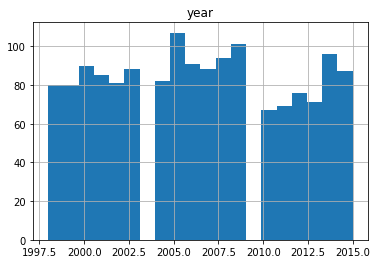

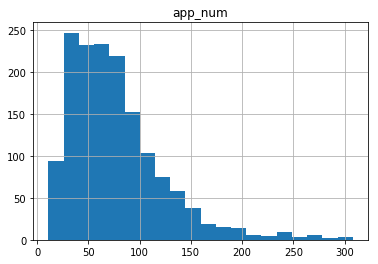

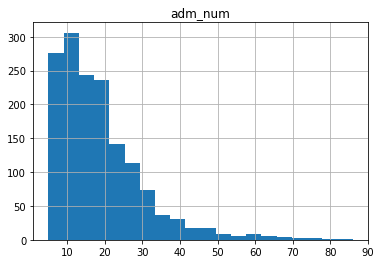

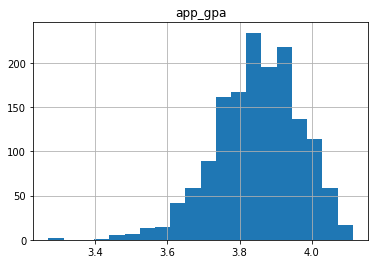

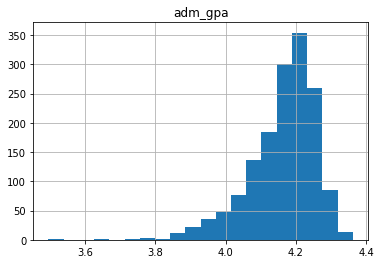

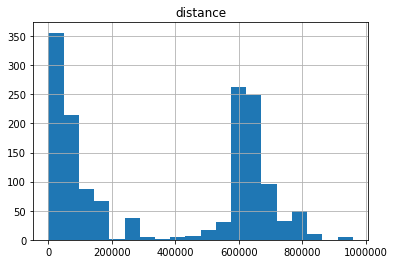

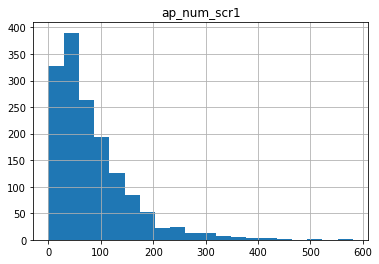

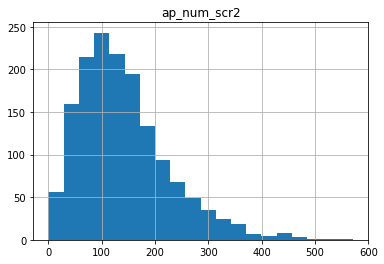

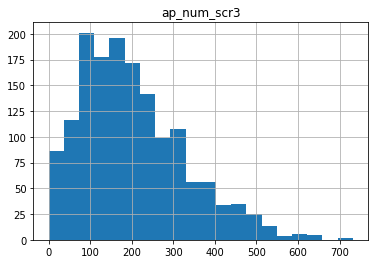

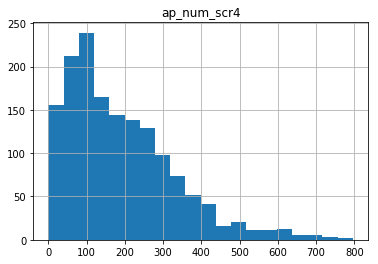

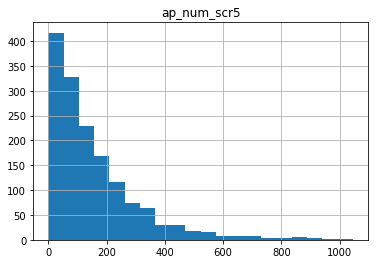

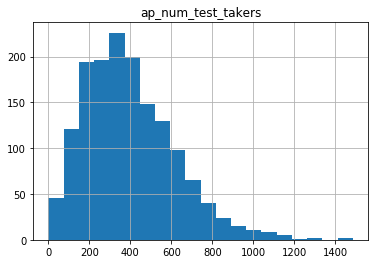

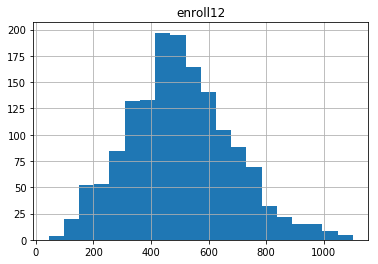

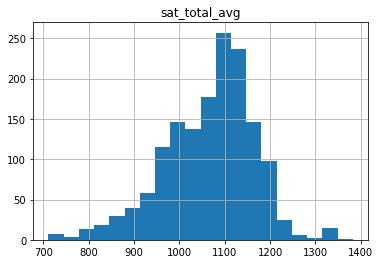

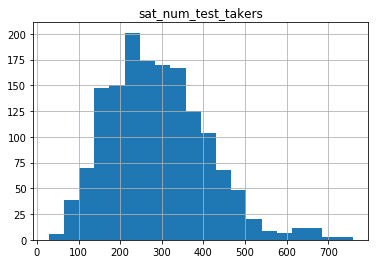

In [61]:
for col in X.columns:
    plt.figure()
    plt.title(col)
    X[col].hist(bins=20)

## Normalize all the data by taking z-scores

In [145]:
def z_score(X):
    return (X-X.mean(axis=0)) / X.std(axis=0)

def undo_z_score(to_undo, orig_sample):
    return (to_undo * orig_sample.std(axis=0)) + orig_sample.mean(axis=0)

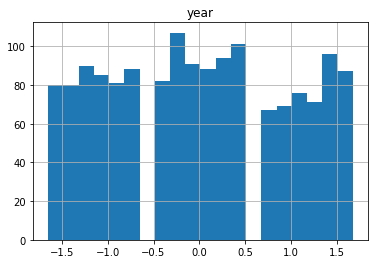

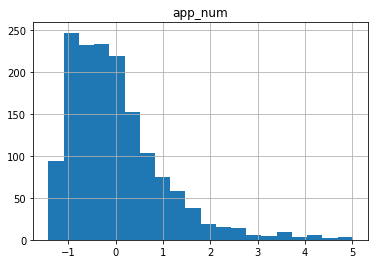

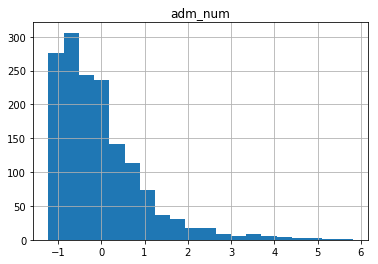

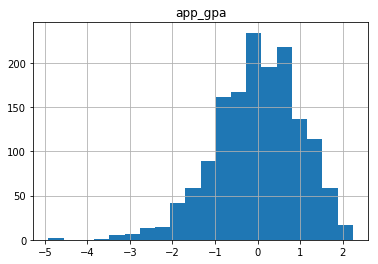

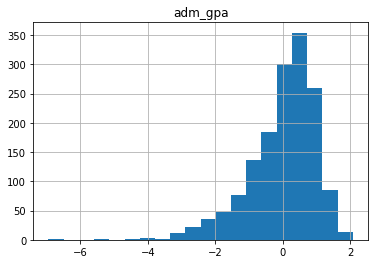

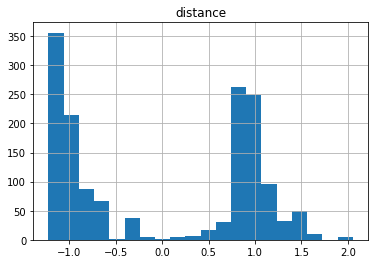

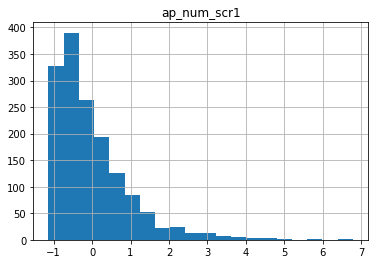

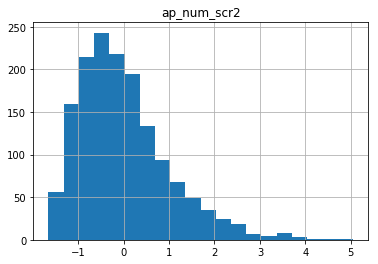

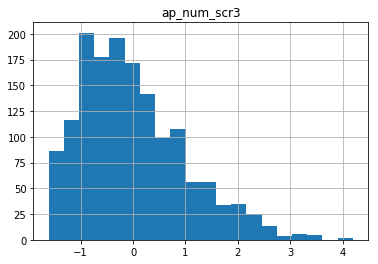

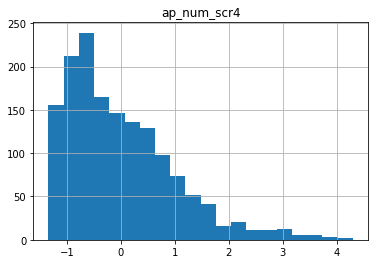

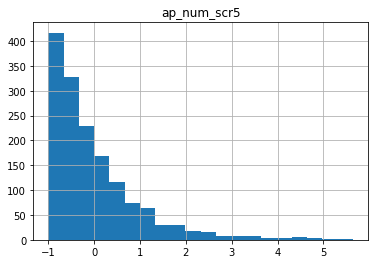

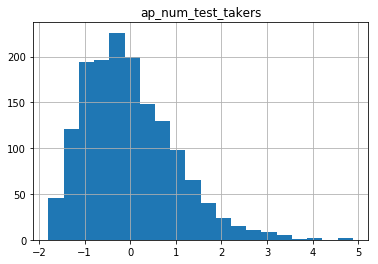

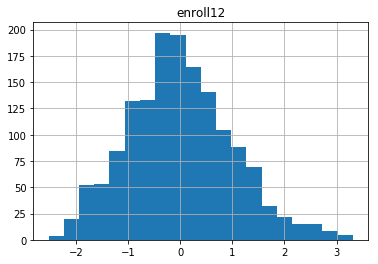

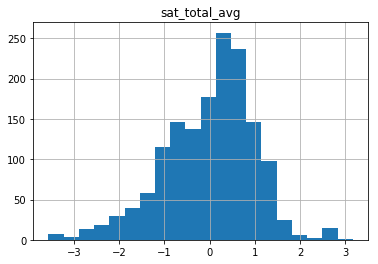

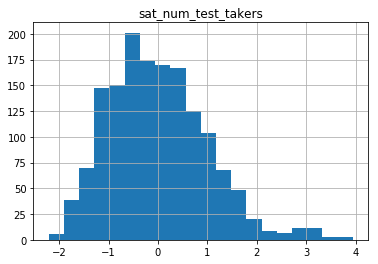

In [64]:
for col in X_z.columns:
    plt.figure()
    plt.title(col)
    X_z[col].hist(bins=20)

## Split the data into train and test sets
Use all early years for training, and later years for testing. This is to emulate the real fact that universities would train and evaluate this way.

In [65]:
RATIO = .7
years = X_z['year'].unique()
cutoff_year = years[  int(math.ceil(len(years)*RATIO))  ]
train_idxs, test_idxs = X_z['year'] <= cutoff_year, X_z['year'] > cutoff_year

In [140]:
X_train, X_test = z_score(X[train_idxs]), z_score(X[test_idxs])
y_train, y_test = z_score(y[train_idxs]), z_score(y[test_idxs])
school_num_train, school_num_test = relevant['school_num'][train_idxs], relevant['school_num'][test_idxs]
year_train, year_test = relevant['year'][train_idxs], relevant['year'][test_idxs]

## Some helpers

In [84]:
def hs_name_to_code(hs_name):
    return list(df[df['school'] == hs_name]['school_num'])[0]

def get_hs_yield(df, hs_code, uc_campus, year):
    data_filter = (df['school_num'] == hs_code) & (df['campus'] == uc_campus) & (df['year'] == year)
    _yield = df[data_filter]['yield']
    try:
        return list(_yield)[0]
    except IndexError:
        return np.nan
    
def get_year_yields(df):
    campuses = df['campus'].unique()
    yields = {}
    for campus in campuses:
        df_for_campus = df[df['campus'] == campus]
        enrolled_and_admitted = df_for_campus.groupby('year')[['enr_num', 'adm_num']].sum()
        yields[campus] = enrolled_and_admitted['enr_num']/enrolled_and_admitted['adm_num']
    
    return pd.DataFrame(yields)

In [85]:
get_year_yields(data)

,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,Santa Barbara,Santa Cruz,Universitywide
year,,,,,,,,,,
1994.0,0.302956,0.212993,0.199874,0.305794,NaN,0.132991,0.166199,0.115373,0.104854,0.581263
1995.0,0.295235,0.200160,0.216509,0.304379,NaN,0.146085,0.186360,0.146601,0.098895,0.574699
1996.0,0.327978,0.227650,0.224947,0.299020,NaN,0.123622,0.159926,0.151788,0.110922,0.573942
1997.0,0.325768,0.228754,0.194361,0.304281,NaN,0.174435,0.174013,0.181559,0.107784,0.578603
1998.0,0.366058,0.228620,0.218585,0.343574,NaN,0.200938,0.190157,0.170117,0.108050,0.578841
1999.0,0.333452,0.218579,0.224460,0.372234,NaN,0.147336,0.184749,0.181956,0.114438,0.573121
2000.0,0.347665,0.229294,0.212341,0.336285,NaN,0.151262,0.160324,0.151125,0.117590,0.578594
2001.0,0.333015,0.208107,0.199556,0.345691,NaN,0.145440,0.187922,0.130175,0.097981,0.558751
2002.0,0.321347,0.225400,0.188443,0.343003,NaN,0.151504,0.202469,0.145919,0.103683,0.558401


## Model evaluation

In [126]:
def rms_evaluate_model(df, hs_codes, years):
    pass

def predictions_to_yearly(df, hs_codes, years, predictions):
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    adm_and_enr_by_year = {}
    for i in range(len(hs_codes)):
        if years[i] in adm_and_enr_by_year:
            adm_and_enr = adm_and_enr_by_year[years[i]]
        else:
            adm_and_enr = {'adm': 0, 'enr': 0}
            adm_and_enr_by_year[years[i]] = adm_and_enr
        admitted_count = df[(df['school_num'] == hs_codes[i]) & (df['year'] == years[i])]['adm_num'].values[0]
        adm_and_enr['adm'] += admitted_count
        adm_and_enr['enr'] += admitted_count * predictions[i]
    return adm_and_enr_by_year

def evaluate_yearly_predictions(yearly_preds, expected_yields):
    result = {}
    for year in yearly_preds:
        result[year] = {
            'expected': list(expected_yields[expected_yields.index == year].values)[0],
            'predicted': yearly_preds[year]['enr']/yearly_preds[year]['adm'],
            'adm': yearly_preds[year]['adm'],
            'predicted_enr': yearly_preds[year]['enr'],
        }
        result[year]['rms'] = (result[year]['expected'] - result[year]['predicted'])**2
    return result

## Baseline model

,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,Santa Barbara,Santa Cruz,Universitywide
year,,,,,,,,,,
1994.0,0.302956,0.212993,0.199874,0.305794,NaN,0.132991,0.166199,0.115373,0.104854,0.581263
1995.0,0.295235,0.200160,0.216509,0.304379,NaN,0.146085,0.186360,0.146601,0.098895,0.574699
1996.0,0.327978,0.227650,0.224947,0.299020,NaN,0.123622,0.159926,0.151788,0.110922,0.573942
1997.0,0.325768,0.228754,0.194361,0.304281,NaN,0.174435,0.174013,0.181559,0.107784,0.578603
1998.0,0.366058,0.228620,0.218585,0.343574,NaN,0.200938,0.190157,0.170117,0.108050,0.578841
1999.0,0.333452,0.218579,0.224460,0.372234,NaN,0.147336,0.184749,0.181956,0.114438,0.573121
2000.0,0.347665,0.229294,0.212341,0.336285,NaN,0.151262,0.160324,0.151125,0.117590,0.578594
2001.0,0.333015,0.208107,0.199556,0.345691,NaN,0.145440,0.187922,0.130175,0.097981,0.558751
2002.0,0.321347,0.225400,0.188443,0.343003,NaN,0.151504,0.202469,0.145919,0.103683,0.558401


In [130]:
def get_baseline_pred_for_hs(df, hs_code, year):
    PAST_YEARS_CNT = 10
    DEFAULT_PREDICTION = 0.45
    prev_years_data = df[(df['school_num'] == hs_code) & (df['year'] < year) & (df['year'] > (year - PAST_YEARS_CNT))]
    prediction = prev_years_data['yield'].mean()
    if math.isnan(prediction):
        return DEFAULT_PREDICTION
    else:
        return prediction
    
def baseline_pred(df, hs_codes, years):
    assert(len(hs_codes) == len(years))
    predictions = []
    for i in range(len(hs_codes)):
        predictions.append(get_baseline_pred_for_hs(df, hs_codes.values[i], years.values[i]))
    return predictions


In [131]:
base_pred = baseline_pred(relevant, school_num_test, year_test)
yearly = predictions_to_yearly(relevant, school_num_test, year_test, base_pred)
evaluate_yearly_predictions(yearly, get_year_yields(berkeley_data))

{2012.0: {'adm': 1340.0,
  'expected': array([0.30493781]),
  'predicted': 0.4954549636759821,
  'predicted_enr': 663.909651325816,
  'rms': array([0.03629679])},
 2013.0: {'adm': 1282.0,
  'expected': array([0.31232769]),
  'predicted': 0.4936460396805713,
  'predicted_enr': 632.8542228704924,
  'rms': array([0.03287634])},
 2014.0: {'adm': 1625.0,
  'expected': array([0.42722117]),
  'predicted': 0.498916821125703,
  'predicted_enr': 810.7398343292674,
  'rms': array([0.00514027])},
 2015.0: {'adm': 1847.0,
  'expected': array([0.33742708]),
  'predicted': 0.5048360033780089,
  'predicted_enr': 932.4320982391826,
  'rms': array([0.02802575])}}

## make and fit a linear regressor

In [141]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [164]:
y_pred = reg.predict(X_test)
data_result = pd.DataFrame(data={'z-actual':y_test.values.flatten(),
                                 'z-predicted':y_pred.flatten(),
                                 'school_num': school_num_test.values.flatten(),
                                 'year': year_test.values.flatten(),
                                 'predicted': undo_z_score(y_pred.flatten(), y[test_idxs]['yield'])}) 

yearly = predictions_to_yearly(relevant, data_result['school_num'], data_result['year'], data_result['predicted'])
evaluate_yearly_predictions(yearly, get_year_yields(berkeley_data))

{2012.0: {'adm': 1340.0,
  'expected': array([0.30493781]),
  'predicted': 0.5314861239760662,
  'predicted_enr': 712.1914061279288,
  'rms': array([0.05132414])},
 2013.0: {'adm': 1282.0,
  'expected': array([0.31232769]),
  'predicted': 0.5327427145674544,
  'predicted_enr': 682.9761600754765,
  'rms': array([0.04858278])},
 2014.0: {'adm': 1625.0,
  'expected': array([0.42722117]),
  'predicted': 0.5390262322326596,
  'predicted_enr': 875.9176273780718,
  'rms': array([0.01250037])},
 2015.0: {'adm': 1847.0,
  'expected': array([0.33742708]),
  'predicted': 0.5245560661303751,
  'predicted_enr': 968.8550541428027,
  'rms': array([0.03501726])}}

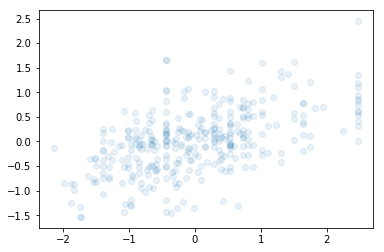

In [143]:
plt.scatter(y_test.values.flatten(), y_pred.flatten(), alpha=.1)

In [144]:
reg.score(X_test, y_test)

0.2911464251317365

In [19]:
import statsmodels.api as sm
X_train2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
est2.summary()

C:\Users\m_wis\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     65.42
Date:                Mon, 14 May 2018   Prob (F-statistic):          1.74e-143
Time:                        23:10:16   Log-Likelihood:                -1344.0
No. Observations:                1203   AIC:                             2720.
Df Residuals:                    1187   BIC:                             2802.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0348      0.025     -1.410      0.159      -0.083       0.014
year                    0.0759      0.042      1.827      0.068      -0.006       0.157
app_num                 0.2336      0.070      3.338      0.001       0.096       0.371
adm_num                -0.3791      0.052     -7.303      0.000      -0.481      -0.277
app_gpa                 0.0003      0.035      0.008      0.994      -0.068       0.068
adm_gpa                -0.1077      0.030     -3.533      0.000      -0.167      -0.048
distance               -0.2911      0.026    -11.294      0.000      -0.342      -0.241
ap_num_scr1            -0.1493      0.051     -2.936      0.003      -0.249      -0.050
ap_num_scr2             0.1270      0.072      1.754      0.080      -0.015       0.269
ap_num_scr3             0.2745      0.120      2.280      0.023       0.038       0.511
ap_num_scr4            -0.4375      0.135     -3.249      0.001      -0.702      -0.173
ap_num_scr5             0.5185      0.093      5.557      0.000       0.335       0.702
ap_num_test_takers     -0.4160      0.126     -3.303      0.001      -0.663      -0.169
enroll12                0.0670      0.040      1.689      0.091      -0.011       0.145
sat_total_avg          -0.3489      0.039     -9.037      0.000      -0.425      -0.273
sat_num_test_takers    -0.0848      0.060     -1.409      0.159      -0.203       0.033
==============================================================================
Omnibus:                       25.457   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.604
Skew:                           0.346   Prob(JB):                     1.67e-06
Kurtosis:                       3.228   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""